## Preprocessing and Modeling

### Contents:
 - [Import Data](#Import-Data)
 - [Baseline Model](#Baseline-Model)
 - [Model 1: Logistic Regression with Species and Illnesses Features](#Model-1:-Logistic-Regression-with-Species-and-Illnesses-Features)
 
 -[Model 2: Logistic Regression with all Features in Clean Dataset](#Model-2:-Logistic-Regression-with-all-Features-in-Clean-Dataset)
 -[Model 3: Logistic Regression with State, Location, Food, Species, Illnesses](#Model-3:-Logistic-Regression-with-State,-Location,-Food,-Species,-Illnesses )
 - [Model 4: Naive Bayes with State, Location, Food, Species, Illnesses ](#Model-4:-Naive-Bayes-with-State,-Location,-Food,-Species,-Illnesses )
 - [Model 5: Decision Tree with State, Location, Food, Species, Illnesses](#Model-5:-Decision-Tree-with-State,-Location,-Food,-Species,-Illnesses )
 - [Model 6: KNN with State, Location, Food, Species, Illnesses](#Model-6:-KNN-with-State,-Location,-Food,-Species,-Illnesses )

In [4]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from category.encoders import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier 

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

## Import Data

In [6]:
df_clean = pd.read_csv('../data/clean_df.csv')

df_clean.drop('Unnamed: 0', axis =1, inplace = True)

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6025 entries, 0 to 6024
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              6025 non-null   int64  
 1   Month             6025 non-null   object 
 2   State             6025 non-null   object 
 3   Location          5360 non-null   object 
 4   Food              6025 non-null   object 
 5   Species           6025 non-null   object 
 6   Illnesses         6025 non-null   int64  
 7   Hospitalizations  6025 non-null   float64
 8   Fatalities        5851 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 423.8+ KB


In [179]:
df_clean['Hospitalizations'].value_counts(normalize = True)

0    0.640498
1    0.359502
Name: Hospitalizations, dtype: float64

In [6]:
df_clean.head()

Year    Month       State                Location  \
0  1998  January  California              Restaurant   
1  1998  January  California  Private Home/Residence   
2  1998  January  California              Restaurant   
3  1998  January     Florida              Restaurant   
4  1998  January     Florida              Restaurant   

                                      Food                  Species  \
0                                Fish, Ahi          Scombroid toxin   
1        Lasagna, Unspecified; Eggs, Other      Salmonella enterica   
2  Stuffing, Unspecified; Sandwich, Turkey      Salmonella enterica   
3                Ethnic Style, Unspecified  Clostridium perfringens   
4                Ground Beef, Cheeseburger    Staphylococcus aureus   

   Illnesses  Hospitalizations  Fatalities  
0          4               0.0         0.0  
1         26               3.0         0.0  
2          4               3.0         0.0  
3          3               0.0         0.0  
4          2               0.0         0.0

In [8]:
df_clean['Hospitalizations'] = np.where(df_clean['Hospitalizations'] > 0, 1, 0)

In [160]:
X = df_clean[['Species','Illnesses']]

y = df_clean['Hospitalizations']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 22)

## Baseline Model

In [161]:
dc = DummyClassifier(strategy = 'most_frequent') 
dc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [162]:
dc.score(X_test, y_test)

0.6403450564034505

In [163]:
preds = dc.predict(X_test)

In [165]:
print(1- recall_score(y_test, pred))
print(f1_score(y_test, pred))

0.8800738007380073
0.20344287949921752


Metric: f1 and false negative 


## Model 1: Logistic Regression with Species and Illnesses Features

In [97]:
pipe1 = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), LogisticRegression())

params1 = {'logisticregression__C': [.001, .01, .1, 1, 10, 100]
}

gs_lrg1 = GridSearchCV(pipe1, params1, n_jobs=-1)

gs_lrg1.fit(X_train, y_train)

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]})

In [98]:
print(gs_lrg1.score(X_train, y_train))

print(gs_lrg1.score(X_test, y_test))

print(gs_lrg1.best_params_)

0.8072155821159805
0.809555408095554
{'logisticregression__C': 0.1}


In [99]:
coefs1 = gs_lrg1.best_estimator_.named_steps['logisticregression'].coef_

features1 = gs_lrg1.best_estimator_.named_steps['onehotencoder'].get_feature_names()

coef_df1 = pd.DataFrame({'coefs': coefs1[0], 
                        'features': features1})

print(f'Largest Coef:')
print(coef_df1.nlargest(10, 'coefs'))

print(f'Smallest Coef:')
print(coef_df1.nsmallest(10, 'coefs'))

Largest Coef:
        coefs                                           features
133  0.761921                                          Illnesses
0    0.682441                        Species_Salmonella enterica
3    0.572767    Species_Escherichia coli, Shiga toxin-producing
34   0.425950                      Species_Clostridium botulinum
12   0.324172                     Species_Listeria monocytogenes
48   0.161330                           Species_Brucella unknown
89   0.160949                     Species_Plant or herbal toxins
29   0.157286  Species_Salmonella enterica; Campylobacter jejuni
41   0.146439  Species_Salmonella enterica; Salmonella enteri...
36   0.136906                           Species_Salmonella other
Smallest Coef:
       coefs                                          features
9  -0.496518                   Species_Clostridium perfringens
8  -0.304111                           Species_Scombroid toxin
6  -0.297981                     Species_Norovirus genogroup I
14 -

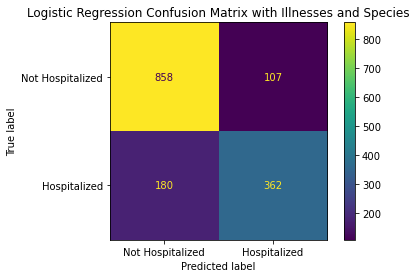

In [100]:
plot_confusion_matrix(gs_lrg1, X_test, y_test, display_labels = ['Not Hospitalized', 'Hospitalized'])
plt.title('Logistic Regression Confusion Matrix with Illnesses and Species');

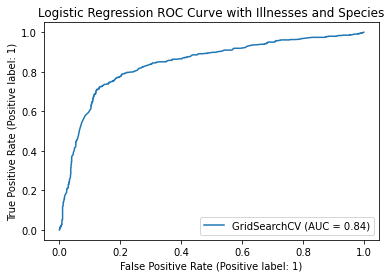

In [101]:
plot_roc_curve(gs_lrg1, X_test, y_test)
plt.title('Logistic Regression ROC Curve with Illnesses and Species');

In [75]:
pred = gs_lrg1.predict(X_test)

print(1 - recall_score(y_test, pred)) #false negatives FN/FN+TP

print(f1_score(y_test, pred)) #precision and recall looking to see if low false positive and low false negative rates 

## Model 2: Logistic Regression with all Features in Clean Dataset

In [166]:
X = df_clean.drop('Hospitalizations', axis = 1)

y = df_clean['Hospitalizations']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 22)

In [167]:
pipe2 = make_pipeline(OneHotEncoder(use_cat_names = True), SimpleImputer(strategy = 'most_frequent'), StandardScaler(), LogisticRegression())

params2 = {'logisticregression__C': [.001, .01, .1, 1, 10, 100]
}

gs_lrg2 = GridSearchCV(pipe2, params2, n_jobs=-1)

gs_lrg2.fit(X_train, y_train)

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]})

In [168]:
print(gs_lrg2.score(X_train, y_train))

print(gs_lrg2.score(X_test, y_test))

print(gs_lrg2.best_params_)

0.8911022576361222
0.7763769077637691
{'logisticregression__C': 0.01}


In [109]:
coefs2 = gs_lrg2.best_estimator_.named_steps['logisticregression'].coef_

features2 = gs_lrg2.best_estimator_.named_steps['onehotencoder'].get_feature_names()

coef_df2 = pd.DataFrame({'coefs': coefs2[0], 
                        'features': features2})

print(f'Largest Coef:')
print(coef_df2.nlargest(30, 'coefs'))

print(f'Smallest Coef:')
print(coef_df2.nsmallest(10, 'coefs'))

Largest Coef:
         coefs                                           features
1911  0.592229                        Species_Salmonella enterica
1914  0.448730    Species_Escherichia coli, Shiga toxin-producing
2044  0.320392                                          Illnesses
1945  0.290477                      Species_Clostridium botulinum
2045  0.191436                                         Fatalities
1923  0.151129                     Species_Listeria monocytogenes
1912  0.134362                                 Species_Mycotoxins
23    0.133439                                   State_Multistate
1932  0.118051                            Species_Shigella sonnei
1941  0.111512                                Species_Hepatitis A
725   0.103299                               Food_Chips And Salsa
97    0.103235                        Location_Religious Facility
1940  0.099554  Species_Salmonella enterica; Campylobacter jejuni
26    0.096299                                     State_New Y

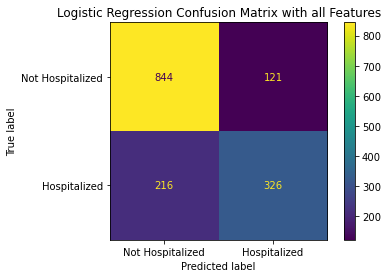

In [110]:
plot_confusion_matrix(gs_lrg2, X_test, y_test, display_labels = ['Not Hospitalized', 'Hospitalized'])
plt.title('Logistic Regression Confusion Matrix with all Features');

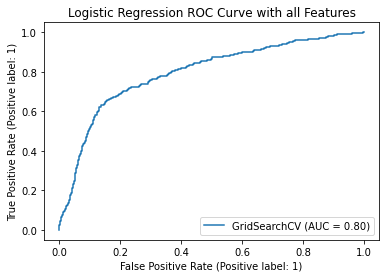

In [111]:
plot_roc_curve(gs_lrg2, X_test, y_test)
plt.title('Logistic Regression ROC Curve with all Features');

In [169]:
pred = gs_lrg2.predict(X_test)

print(1- recall_score(y_test, pred))

print(f1_score(y_test, pred))

0.39852398523985244
0.6592517694641051


## Model 3: Logistic Regression with State, Location, Food, Species, Illnesses 

In [116]:
X = df_clean[['State', 'Location', 'Food', 'Species', 'Illnesses']]

y = df_clean['Hospitalizations']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 22)

In [117]:
pipe3 = make_pipeline(OneHotEncoder(use_cat_names = True), SimpleImputer(strategy = 'most_frequent'), StandardScaler(), LogisticRegression())

params3 = {'logisticregression__C': [.001, .01, .1, 1, 10, 100]
}

gs_lrg3 = GridSearchCV(pipe3, params3, n_jobs=-1)

gs_lrg3.fit(X_train, y_train)

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]})

In [118]:
print(gs_lrg3.score(X_train, y_train))

print(gs_lrg3.score(X_test, y_test))

print(gs_lrg3.best_params_)

0.8884462151394422
0.774386197743862
{'logisticregression__C': 0.01}


In [119]:
coefs3 = gs_lrg3.best_estimator_.named_steps['logisticregression'].coef_

features3 = gs_lrg3.best_estimator_.named_steps['onehotencoder'].get_feature_names()

coef_df3 = pd.DataFrame({'coefs': coefs3[0], 
                        'features': features3})

print(f'Largest Coef:')
print(coef_df3.nlargest(30, 'coefs'))

print(f'Smallest Coef:')
print(coef_df3.nsmallest(10, 'coefs'))

Largest Coef:
         coefs                                           features
1898  0.596140                        Species_Salmonella enterica
1901  0.452429    Species_Escherichia coli, Shiga toxin-producing
2031  0.325498                                          Illnesses
1932  0.291536                      Species_Clostridium botulinum
1910  0.179627                     Species_Listeria monocytogenes
10    0.140906                                   State_Multistate
1899  0.134148                                 Species_Mycotoxins
1928  0.117140                                Species_Hepatitis A
1919  0.116828                            Species_Shigella sonnei
84    0.104062                        Location_Religious Facility
712   0.102910                               Food_Chips And Salsa
67    0.098544              Location_Private Home/Residence; Camp
1927  0.097736  Species_Salmonella enterica; Campylobacter jejuni
3     0.095618                                         State_O

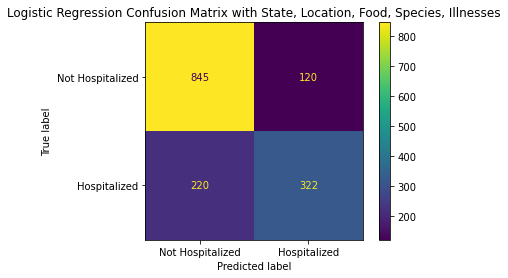

In [121]:
plot_confusion_matrix(gs_lrg3, X_test, y_test, display_labels = ['Not Hospitalized', 'Hospitalized'])
plt.title('Logistic Regression Confusion Matrix with State, Location, Food, Species, Illnesses');

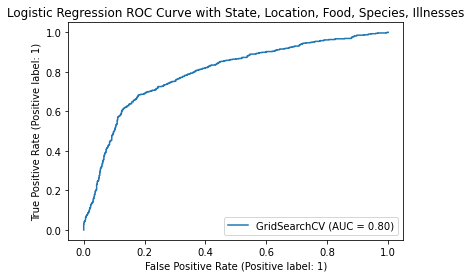

In [122]:
plot_roc_curve(gs_lrg3, X_test, y_test)
plt.title('Logistic Regression ROC Curve with State, Location, Food, Species, Illnesses');

In [123]:
pred = gs_lrg3.predict(X_test)

print(1- recall_score(y_test, pred))

print(f1_score(y_test, pred))

0.40590405904059046
0.6544715447154472


## Model 4: Naive Bayes with State, Location, Food, Species, Illnesses 

In [129]:
pipe4 = make_pipeline(OneHotEncoder(use_cat_names = True), SimpleImputer(strategy = 'most_frequent'), MultinomialNB())

params4 = {'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]
}

gs_bay4 = GridSearchCV(pipe4, params4, n_jobs=-1)

gs_bay4.fit(X_train, y_train)

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]})

In [130]:
print(gs_bay4.score(X_train, y_train))

print(gs_bay4.score(X_test, y_test))

print(gs_bay4.best_params_)

0.7959274015050908
0.7405441274054413
{'multinomialnb__alpha': 1.0}


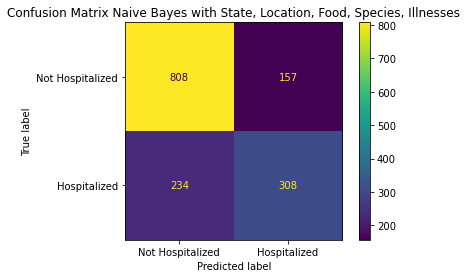

In [132]:
plot_confusion_matrix(gs_bay4, X_test, y_test, display_labels = ['Not Hospitalized', 'Hospitalized'])
plt.title('Confusion Matrix Naive Bayes with State, Location, Food, Species, Illnesses');

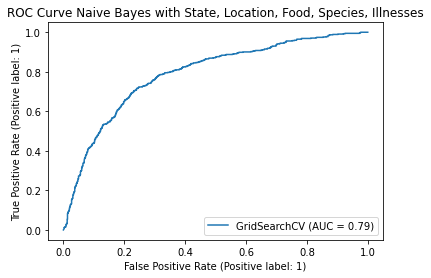

In [136]:
plot_roc_curve(gs_bay4, X_test, y_test)
plt.title('ROC Curve Naive Bayes with State, Location, Food, Species, Illnesses');

In [133]:
pred = gs_bay4.predict(X_test)

print(1- recall_score(y_test, pred))

print(f1_score(y_test, pred))

0.43173431734317347
0.6117179741807348


## Model 5: Decision Tree with State, Location, Food, Species, Illnesses 

In [142]:
pipe5 = make_pipeline(OneHotEncoder(use_cat_names = True), SimpleImputer(strategy = 'most_frequent'), DecisionTreeClassifier())

params5 = {'decisiontreeclassifier__max_depth': [5,10,50]}

gs_tree5 = GridSearchCV(pipe5, params5, n_jobs=-1)

gs_tree5.fit(X_train, y_train)

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [5, 10, 50]})

In [143]:
print(gs_tree5.score(X_train, y_train))

print(gs_tree5.score(X_test, y_test))

print(gs_tree5.best_params_)

0.8244798583444002
0.8002654280026543
{'decisiontreeclassifier__max_depth': 10}


In [146]:
importance5 = gs_tree5.best_estimator_.named_steps['decisiontreeclassifier'].feature_importances_

features5 = gs_tree5.best_estimator_.named_steps['onehotencoder'].get_feature_names()

importance_df5 = pd.DataFrame({'importance': importance5, 
                        'features': features5})

print(f'Largest Feature Importance:')
print(importance_df5.nlargest(30, 'importance'))

print(f'Smallest Feature Importance:')
print(importance_df5.nsmallest(10, 'importance'))

Largest Feature Importance:
      importance                                         features
1898    0.331209                      Species_Salmonella enterica
1901    0.182195  Species_Escherichia coli, Shiga toxin-producing
2031    0.126568                                        Illnesses
1932    0.054565                    Species_Clostridium botulinum
1910    0.038289                   Species_Listeria monocytogenes
1907    0.018854                  Species_Clostridium perfringens
56      0.015690                  Location_Private Home/Residence
1919    0.012824                          Species_Shigella sonnei
1928    0.011406                              Species_Hepatitis A
54      0.008708                              Location_Restaurant
1899    0.007881                               Species_Mycotoxins
3       0.006866                                       State_Ohio
1946    0.006747                         Species_Brucella unknown
4       0.006224                                

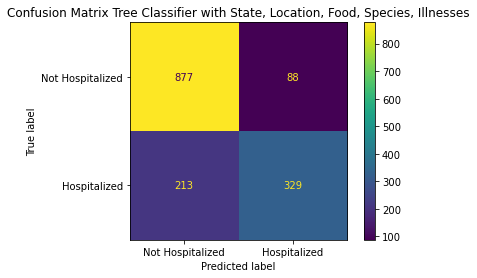

In [147]:
plot_confusion_matrix(gs_tree5, X_test, y_test, display_labels = ['Not Hospitalized', 'Hospitalized'])
plt.title('Confusion Matrix Tree Classifier with State, Location, Food, Species, Illnesses');

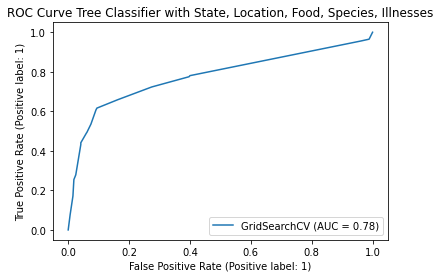

In [149]:
plot_roc_curve(gs_tree5, X_test, y_test)
plt.title('ROC Curve Tree Classifier with State, Location, Food, Species, Illnesses');

In [150]:
pred = gs_tree5.predict(X_test)

print(1- recall_score(y_test, pred))

print(f1_score(y_test, pred))

0.3929889298892989
0.6861313868613138


## Model 6: KNN with State, Location, Food, Species, Illnesses 

In [151]:
pipe6 = make_pipeline(OneHotEncoder(use_cat_names = True), SimpleImputer(strategy = 'most_frequent'), StandardScaler(), KNeighborsClassifier())

params6 = {'kneighborsclassifier__n_neighbors': [5,10,20,50]}

gs_knn6 = GridSearchCV(pipe6, params6, n_jobs=-1)

gs_knn6.fit(X_train, y_train)

/Users/annafunsten/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [5, 10, 20, 50]})

In [152]:
print(gs_knn6.score(X_train, y_train))

print(gs_knn6.score(X_test, y_test))

print(gs_knn6.best_params_)

0.6969898185037627
0.6622428666224287
{'kneighborsclassifier__n_neighbors': 10}


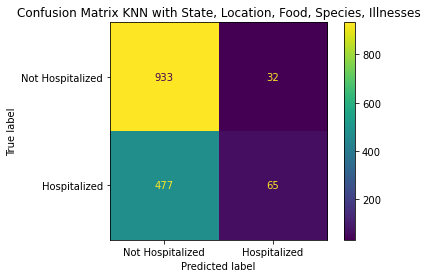

In [153]:
plot_confusion_matrix(gs_knn6, X_test, y_test, display_labels = ['Not Hospitalized', 'Hospitalized'])
plt.title('Confusion Matrix KNN with State, Location, Food, Species, Illnesses');

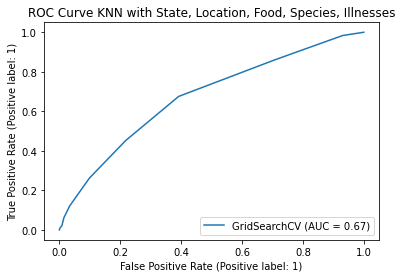

In [154]:
plot_roc_curve(gs_knn6, X_test, y_test)
plt.title('ROC Curve KNN with State, Location, Food, Species, Illnesses');

In [158]:
pred = gs_knn6.predict(X_test)

print(1- recall_score(y_test, pred))

print(f1_score(y_test, pred))

0.8800738007380073
0.20344287949921752
0.5433827887501673
